# This notebook shows how to detect coins by using OpenCV + Metric learning.

# Import Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
from os import path
import numpy as np
import math
import pathlib
import random
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.regularizers as R
import tensorflow.keras.backend as B

# Visulization

In [2]:
class ImgsVisulization():
    def __init__(self):
        pass

    def img(self, img, title=None, dpi=100):
        plt.rcParams['savefig.dpi'] = dpi
        plt.rcParams['figure.dpi'] = dpi
        if title is not None:
            plt.title(title)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img)
        plt.show()

    def imgs(self, imgs, title=None, dpi=100):  
        plt.rcParams['savefig.dpi'] = dpi
        plt.rcParams['figure.dpi'] = dpi
        for i in range(len(imgs)):
            max_row = 12
            if len(imgs) > max_row:
                plt.subplot(math.ceil(len(imgs) / max_row), max_row, i + 1)
            else:
                plt.subplot(1, len(imgs), i + 1)
            plt.axis('off')
            if title is not None:
                plt.title(title[i])
            if len(imgs[i].shape) == 2:
                plt.imshow(imgs[i], cmap='gray', vmin=0, vmax=255)
            else:
                plt.imshow(imgs[i])
        plt.subplots_adjust(wspace=0.00, hspace=0.00)
        plt.show()
    
imgs_visulization = ImgsVisulization()

# Load Test Samples

In [4]:
work_dir = 'E:\Github\CoinsRecognition'

(426, 454, 3) (426, 454, 3)


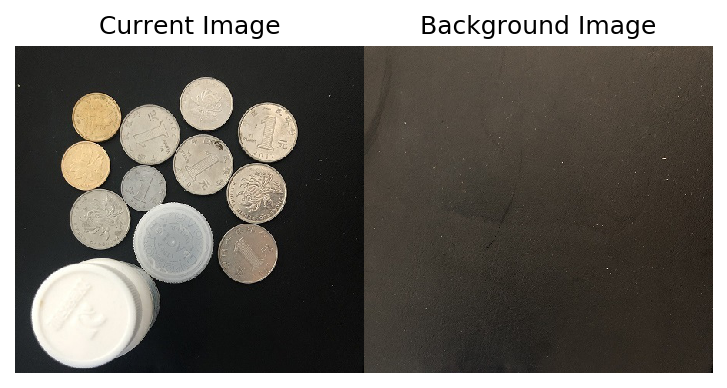

In [5]:
sample_img_curr = plt.imread(path.join(work_dir, 'Test Samples\Img_curr.jpg'))
sample_img_bg = plt.imread(path.join(work_dir, 'Test Samples\Img_bg.jpg'))

print(sample_img_curr.shape, sample_img_bg.shape)
imgs_visulization.imgs([sample_img_curr, sample_img_bg], ["Current Image", "Background Image"], dpi=150)

# Roi Pooling

In [66]:
class RoiPooling():
    def __init__(self, distance):
        self.distance = distance
        self.holes_fill_threshold = 40
        self.bg_threshold = 60
        self.min_radius = 10
        self.max_radius = 1000
    
    def _foreground_extract(self, img_curr, img_bg):
        img_curr = cv2.cvtColor(img_curr, cv2.COLOR_RGB2GRAY)
        img_bg = cv2.cvtColor(img_bg, cv2.COLOR_RGB2GRAY)
        img_bg = cv2.GaussianBlur(img_bg, (3, 3), 5)
        img_curr = cv2.GaussianBlur(img_curr, (3, 3), 5)

        res = np.where(img_curr > img_bg, img_curr - img_bg, img_bg - img_curr)
        res = np.where(res > self.bg_threshold, 255, 0).astype(np.uint8)
        #res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, np.ones((3, 3),np.uint8))
        contours, _ = cv2.findContours(255 - res, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours = [contour for contour in contours if cv2.contourArea(contour) <= self.holes_fill_threshold]
        res = cv2.drawContours(res, contours, -1, (255, 255, 255), -1)
        return res
    
    def _segmentation(self, img_curr, mask):
        # Find all peaks of "distanceTransform"
        dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
        loc_max = np.logical_and(cv2.dilate(dist_transform, np.ones((3, 3),np.uint8)) == dist_transform,
                                 np.logical_and(dist_transform > self.min_radius, dist_transform < self.max_radius))
        loc_max = [(x, y, math.ceil(dist_transform[y, x])) for y in range(loc_max.shape[0]) for x in range(loc_max.shape[1]) if loc_max[y, x]]
        loc_max.sort(key=lambda x: x[-1], reverse=True)
        # Filter points on the borders
        closed_mask = np.zeros(mask.shape, np.uint8)
        res = []
        for (x, y, r) in loc_max:
            if closed_mask[y, x] == 0:
                res.append((x, y, r))
                cv2.circle(closed_mask, (x, y), int(r * 1.2), 255, -1)
        return res
    
    def get_roi_info(self, img_curr, img_bg):
        fg_mask = self._foreground_extract(img_curr, img_bg)
        # imgs_visulization.img(fg_mask, "Foreground Detection")
        proposals = self._segmentation(img_curr, fg_mask)
        return proposals

    def get_roi_img(self, img_bg, proposals):
        return [img_bg[max(y - r, 0):(y + r), max(x - r, 0):(x + r), :] for (x, y, r) in proposals]
        
    def display_roi(self, img_bg, proposals, labels=None):
        img_canvas = img_bg.copy()
        color_dict = {}
        for idx, (x, y, r) in enumerate(proposals):
            id = labels[idx] if (labels is not None) else ""
            if id not in color_dict:
                color_dict[id] = (random.randint(0, 256), random.randint(0, 256), random.randint(0, 256))
            font, scale, thickness = cv2.FONT_HERSHEY_SIMPLEX, 1.0, 3
            cv2.circle(img_canvas, (x, y), int(r), color_dict[id], thickness)
            size, _ = cv2.getTextSize(id, font, scale, thickness)
            cv2.putText(img_canvas, id, (x - size[0]//2, y + size[1]//2), font, scale, color_dict[id], thickness)
        return img_canvas
    
roi_pooling = RoiPooling(5)

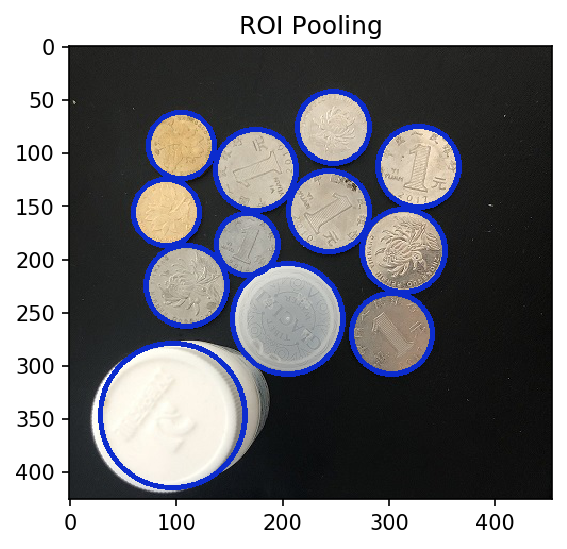

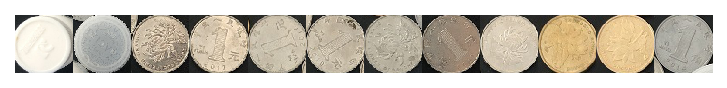

In [67]:
sample_proposals = roi_pooling.get_roi_info(sample_img_curr, sample_img_bg)
imgs_visulization.img(roi_pooling.display_roi(sample_img_curr, sample_proposals), "ROI Pooling", dpi=150)
imgs_visulization.imgs(roi_pooling.get_roi_img(sample_img_curr, sample_proposals), dpi=150)

# Match Coins

In [103]:
class MetricLearningModel():
    class L2NormLayer(L.Layer):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            pass

        def call(self, inputs: tf.Tensor, **kwargs):
            inputs = tf.math.l2_normalize(inputs, axis=1)
            return inputs
        
    def __init__(self):
        image_shape = (224, 224, 3)
        input = tf.keras.Input(shape=image_shape, name='Input')
        #x = ResizeLayer(resize_shape=image_shape)(input)
        #backbone = efn.EfficientNetB0(input_shape=image_shape, include_top=False, weights='imagenet')
        backbone = tf.keras.applications.MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')
        x = backbone(input)
        x = L.GlobalAveragePooling2D(name='Gap')(x)
        x = L.Dense(256, name='Dense', activation=None)(x)
        x = self.L2NormLayer(name="L2")(x)
        output = x
        self.model = tf.keras.Model(input, output, name='Model')
        self.image_shape = image_shape
        
        #self.model.summary()
        
    def load_weights(self, path):
        self.model.load_weights(path, by_name=True, skip_mismatch=True)
        
    def extract_features(self, imgs, steps=None):
        imgs = np.stack([cv2.resize(img, self.image_shape[:2]) for img in imgs])
        return self.model.predict(imgs, verbose=1, steps=steps)
    
    @tf.function
    def _cos_similarity_iter(self, embedding_target, embedding_sources, k):
        distances = tf.matmul(embedding_sources, tf.expand_dims(embedding_target, axis=-1))[:,0] # (#embedding_sources)
        nearset_distances, nearest_idxs = tf.math.top_k(distances, k=tf.minimum(k, tf.shape(distances)[0]), sorted=True)
        nearset_distances, nearest_idxs = tf.cast(nearset_distances, tf.float32), tf.cast(nearest_idxs, tf.float32)
        return tf.stack([nearest_idxs, nearset_distances], axis=1) #(3, 2)
    
    @tf.function
    def cos_similarity(self, embedding_targets, embedding_sources, k):
        return tf.map_fn(lambda x: self._cos_similarity_iter(x, embedding_sources, k), embedding_targets)
    
features_extractor = MetricLearningModel()
features_extractor.load_weights(path.join(work_dir, "model_77_41.7805_0.8527_0.00013.h5"))

In [104]:
sample_features = features_extractor.extract_features([sample_img_curr, sample_img_bg])
similarities = features_extractor.cos_similarity(sample_features, sample_features, 1)
print(similarities)

1/1 [==============================] - 0s 0s/step
tf.Tensor(
[[[0.         1.        ]]

 [[1.         0.99999994]]], shape=(2, 1, 2), dtype=float32)


In [105]:
class Detection():
    def __init__(self):
        train_paths = [str(file_path).replace("\\", "/")
                       for dir_path in [path.join(work_dir, 'Datasets/train/36'), path.join(work_dir, 'Datasets/train/37')]
                       for file_path in pathlib.Path(dir_path).rglob('*.jpg')]
        self.train_label = [{"36": "0.5", "37": "1"}[path.split("/")[-2]] for path in train_paths]
        self.train_features = features_extractor.extract_features([plt.imread(path) for path in train_paths])

    def detect(self, imgs, rerank=5, score_thresold=0.6):
        test_features = features_extractor.extract_features(imgs)
        similarities = features_extractor.cos_similarity(test_features, self.train_features, rerank) # (?, rerank, 2)
        summary = []
        for v0 in similarities:
            summary_iter = {}
            for v1 in v0: # Iterate Rerank
                label, similarity = self.train_label[int(v1[0])], v1[1].numpy()
                if similarity >= score_thresold:
                    summary_iter[label] = similarity + (summary_iter[label] if (label in summary_iter) else 0)
            if (len(summary_iter.keys()) > 0):
                label = max(zip(summary_iter.values(), summary_iter.keys()))[1]
                summary.append(label)
            else:
                summary.append(None)
        return summary
    
detection = Detection()

4/4 [==============================] - 0s 40ms/step


In [108]:
detection_res = detection.detect(roi_pooling.get_roi_img(sample_img_curr, sample_proposals), rerank=3, score_thresold=0.6)

1/1 [==============================] - 0s 16ms/step


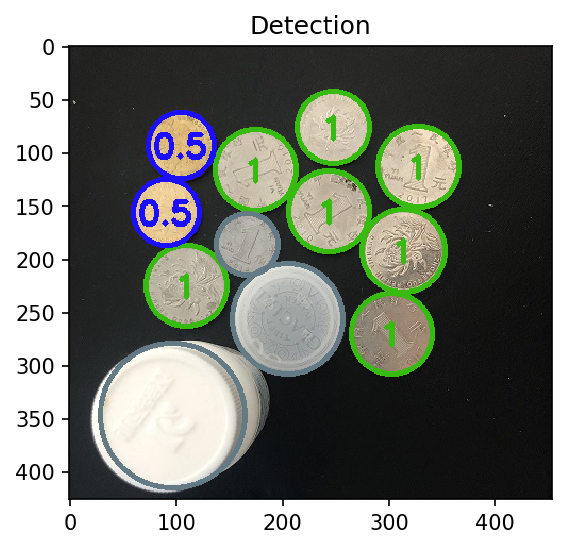

In [112]:
imgs_visulization.img(roi_pooling.display_roi(sample_img_curr, sample_proposals, detection_res), "Detection", dpi=150)